اعطای دستری به درایو گوگل و فراخوانی کتابخانه‌های مورد نیاز و همچنین تعریف مسیرهای مورد استفاده در کد.

In [8]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from tqdm import tqdm
import spacy
import nltk
import re
nltk.download('punkt')
import string
import numpy as np
from PIL import Image
import os

import torch
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import statistics
import torchvision.models as models

caption_dir = '/content/drive/MyDrive/flickr8k/captions.txt'
images_dir = '/content/drive/MyDrive/flickr8k/Images'

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


خواندن دیتاست مربوط به کپشنها و تعیین ایندکسی که داده‌های تست و ترین را از هم جدا میکند. 7/8 داده ها جهت ترین و بقیه جهت تست (در حقیقت ولیدیشن) استفاده میشوند.

In [9]:
df = pd.read_csv(caption_dir)
df = df.reset_index()
train_validation_split_index = int(len(np.unique(df['image'])) * (7/8)) #7/8 az maghale
train_validation_split_index *= 5
image_list = df['image'].tolist()
caption_list = df['caption'].tolist()

عملیات مربوط به پیش پردازش متن که در گزارش به آنها اشاره شد.

In [10]:
spacy_eng = spacy.load("en_core_web_sm")

voc_itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
voc_stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

word_occurness = dict()
idx = 4
for cap in df['caption'].tolist()[:train_validation_split_index]:
  tokenized = [t.text.lower() for t in spacy_eng.tokenizer(cap)]
  for w in tokenized:
    freq = word_occurness.get(w, None)
    if freq is None:
      word_occurness[w] = 1
    else:
      word_occurness[w] += 1
    if word_occurness[w] == 4: #2
      voc_stoi[w] = idx
      voc_itos[idx] = w
      idx+=1

def sent_to_indices(cap):
  tokenized = [t.text.lower() for t in spacy_eng.tokenizer(cap)]
  cap_in_ind = [voc_stoi['<SOS>']]
  [cap_in_ind.append(voc_stoi[token]) if token in voc_stoi else voc_stoi["<UNK>"] for token in tokenized]
  cap_in_ind.append(voc_stoi['<EOS>'])
  return cap_in_ind


تعریف دیتالودرها. چون رم کافی برای ذخیره همزمان کل تصاویر نداریم از دیتالودر استفاده کردیم. همچنین عمل بچ کردن را به کمک دیتالودر انجام دادیم. عملیات مربوط به پیش‌پردازش تصاویر نیز در همین مرحله آمده است.

In [11]:
class MyDataset(Dataset):
    def __init__(self, images_dir, df, vocabs):
        self.images_dir = images_dir        
        self.images = df["image"]
        self.captions = df["caption"]      
        self.vocabs = vocabs        
        self.transform = transforms.Compose(
          [transforms.Resize((356, 356)),
           transforms.RandomCrop((224, 224)),
           transforms.ToTensor(),
           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),]
          )

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, index):
        caption = self.captions[index]
        caption_in_indices = sent_to_indices(caption)        

        image_name = self.images[index]
        img = Image.open(os.path.join(self.images_dir, image_name)).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)

        return img, torch.tensor(caption_in_indices)


class MyCollate:
    def __init__(self, pad_index):
        self.pad_index = pad_index

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_index)
        

        return imgs, targets



train_dataset = MyDataset(images_dir, df[:train_validation_split_index], voc_stoi) 
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory = True, collate_fn = MyCollate(pad_index= voc_stoi["<PAD>"]))

df2 = df[train_validation_split_index:]
df2 = df2.reset_index()
test_dataset = MyDataset(images_dir, df2, voc_stoi) 
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory = True, collate_fn = MyCollate(pad_index= voc_stoi["<PAD>"]))



پیاده سازی مدل اشاره در سوال و مقاله

In [12]:
class image_captioning_CNN(nn.Module):
  def __init__(self, embed_size):
    super(image_captioning_CNN, self).__init__()   
  
    self.resnet = resnet18(weights= ResNet18_Weights)
    self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
    self.relu = nn.ReLU()
    #self.dropout= nn.Dropout(0.5)

  def forward(self, images):
    features = self.resnet(images)
    features = self.relu(features) 
    return features

         
class image_captioning_RNN(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size):
    super(image_captioning_RNN, self).__init__()   

    self.dropout= nn.Dropout(0.5)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(embed_size, hidden_size)
    self.linear = nn.Linear(hidden_size, vocab_size)

  def forward(self, features, captions):
    embeddings = self.dropout(self.embedding(captions))
    embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)##
    outputs, _ = self.lstm(embeddings)
    outputs = self.linear(outputs) ##    
    return outputs

class image_captioning(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
      super(image_captioning, self).__init__()
      self.CNN = image_captioning_CNN(embed_size)
      self.RNN = image_captioning_RNN(embed_size, hidden_size, vocab_size)
    
    def forward(self, images, captions):
      features = self.CNN(images)
      outputs = self.RNN(features, captions)
      return outputs
    
    def validation_forward(self, images, captions):
      max_len = 16
      preds = []
      with torch.no_grad():        
        x = self.CNN(images)
        states = None        
        for _ in range(max_len):
          output, states = self.RNN.lstm(x, states)
          output = self.RNN.linear(output)
          preds.append(output)
          output = torch.argmax(output, axis = 1)
          x = self.RNN.embedding(output)
      return preds
    
    #def caption_image(self, image)

<div dir='rtl'>تعریف پارامترها و مدل - بدون finetune کردن بخش CNN</div>

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_size = 256 #300
hidden_size = 256
vocab_size = len(voc_stoi)
learning_rate = 4e-4
epochs = 10

model0 = (image_captioning(embed_size, hidden_size, vocab_size)).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=voc_stoi['<PAD>'])
optimizer = torch.optim.Adam(model0.parameters(), lr=learning_rate) 

for name, param in model0.CNN.resnet.named_parameters():
  if "fc.weight" in name or "fc.bias" in name:
      param.requires_grad = True
  else:
      param.requires_grad = False #true for finetuning

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


خلاصه مدل تعریف شده (لایه‌ها و...)

In [14]:
model0.eval()

image_captioning(
  (CNN): image_captioning_CNN(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         

آموزش مدل فوق

In [ ]:
training_loss_history = []
validation_loss_history = []
for e in range(10):
  model0.train()
  training_loss = 0 
  for img, cap in tqdm(train_loader):
    img = img.to(device)
    cap = cap.to(device)
    output = model0(img, cap[:-1])
    #print(output.shape, cap.shape)     
    loss = loss_fn(output.reshape(-1, output.shape[2]), cap.reshape(-1))     
    training_loss += loss.item()   

    optimizer.zero_grad()  
    loss.backward()
    clip_grad_norm_(model0.parameters(), 0.001)
    optimizer.step()     
  training_loss = training_loss / len(train_loader)
  print("Epoch: ", e+1, "training_loss: ", training_loss)
  training_loss_history.append(training_loss)    

  print('validation phase: ')
  model0.eval()
  validation_loss = 0
  for img, cap in tqdm(test_loader):
    img = img.to(device)
    if cap.shape[0] > 16:
      cap = cap[0:16]
    else:
      padding = torch.zeros((16 - cap.shape[0], cap.shape[1]))
      cap = torch.cat((cap, padding), 0)
    cap = cap.type(torch.LongTensor) 
    cap = cap.to(device)    
    output = model0.validation_forward(img, cap[:-1])    
    output = torch.tensor(np.array([t.detach().cpu().numpy() for t in output])).to(device)        
    loss = loss_fn(output.reshape(-1, output.shape[2]), cap.reshape(-1))    
    validation_loss += loss.item()   
  validation_loss /= len(test_loader)
  print("Epoch: ", e+1, "validation_loss: ", validation_loss)
  validation_loss_history.append(validation_loss)    

100%|██████████| 2213/2213 [31:27<00:00,  1.17it/s]


Epoch:  1 training_loss:  3.5384015768726003
validation phase: 


100%|██████████| 317/317 [05:14<00:00,  1.01it/s]


Epoch:  1 validation_loss:  6.8792816562231405


100%|██████████| 2213/2213 [06:05<00:00,  6.05it/s]


Epoch:  2 training_loss:  2.9702410928490903
validation phase: 


100%|██████████| 317/317 [00:55<00:00,  5.75it/s]


Epoch:  2 validation_loss:  7.826054183466577


100%|██████████| 2213/2213 [06:06<00:00,  6.04it/s]


Epoch:  3 training_loss:  2.7748549448867434
validation phase: 


100%|██████████| 317/317 [00:52<00:00,  6.01it/s]


Epoch:  3 validation_loss:  8.201565182923519


100%|██████████| 2213/2213 [05:57<00:00,  6.19it/s]


Epoch:  4 training_loss:  2.6489524193279785
validation phase: 


100%|██████████| 317/317 [00:52<00:00,  6.07it/s]


Epoch:  4 validation_loss:  8.540415864637598


100%|██████████| 2213/2213 [05:46<00:00,  6.38it/s]


Epoch:  5 training_loss:  2.5588977068083567
validation phase: 


100%|██████████| 317/317 [00:52<00:00,  6.08it/s]


Epoch:  5 validation_loss:  8.715415082143307


100%|██████████| 2213/2213 [05:52<00:00,  6.28it/s]


Epoch:  6 training_loss:  2.487910819226027
validation phase: 


100%|██████████| 317/317 [00:53<00:00,  5.94it/s]


Epoch:  6 validation_loss:  9.162091744058891


100%|██████████| 2213/2213 [06:05<00:00,  6.05it/s]


Epoch:  7 training_loss:  2.4315621449944125
validation phase: 


100%|██████████| 317/317 [00:52<00:00,  6.02it/s]


Epoch:  7 validation_loss:  9.557825377310865


100%|██████████| 2213/2213 [06:00<00:00,  6.13it/s]


Epoch:  8 training_loss:  2.383739140526073
validation phase: 


100%|██████████| 317/317 [00:53<00:00,  5.96it/s]


Epoch:  8 validation_loss:  9.976013210669677


100%|██████████| 2213/2213 [05:56<00:00,  6.21it/s]


Epoch:  9 training_loss:  2.3430187603601005
validation phase: 


100%|██████████| 317/317 [00:53<00:00,  5.91it/s]


Epoch:  9 validation_loss:  10.356563098799167


100%|██████████| 2213/2213 [05:55<00:00,  6.22it/s]


Epoch:  10 training_loss:  2.30652367880158
validation phase: 


100%|██████████| 317/317 [00:54<00:00,  5.85it/s]

Epoch:  10 validation_loss:  10.169093980398088


پیش بینی تصاویر

In [8]:
class MyDataset2(Dataset):
    def __init__(self, images_dir, df, vocabs):
        self.images_dir = images_dir        
        self.images = df["image"]
        self.captions = df["caption"]      
        self.vocabs = vocabs        
        self.transform = transforms.Compose(
          [transforms.Resize((356, 356)),
           transforms.RandomCrop((224, 224)),
           transforms.ToTensor(),
           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),]
          )

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, index):
        caption = self.captions[index]
        caption_in_indices = sent_to_indices(caption)        

        image_name = self.images[index]
        img = Image.open(os.path.join(self.images_dir, image_name)).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)

        return img, torch.tensor(caption_in_indices), Image.open(os.path.join(self.images_dir, image_name)).convert("RGB")


class MyCollate2:
    def __init__(self, pad_index):
        self.pad_index = pad_index

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_index)
        img_show = [item[2] for item in batch]

        return imgs, targets, img_show



#test_dataset2 = MyDataset2(images_dir, df[:train_validation_split_index], voc_stoi) 
#test_loader2 = DataLoader(test_dataset2, batch_size=16, shuffle=True, num_workers=2, pin_memory = True, collate_fn = MyCollate(pad_index= voc_stoi["<PAD>"]))

df2 = df[train_validation_split_index:]
df2 = df2.reset_index()
test_dataset2 = MyDataset2(images_dir, df2, voc_stoi) 
test_loader2 = DataLoader(test_dataset2, batch_size=3, shuffle=True, num_workers=2, pin_memory = True, collate_fn = MyCollate2(pad_index= voc_stoi["<PAD>"]))



<SOS>
a
people
are
a
snowy
hill
snowy
mountain
.
<EOS>
<EOS>
.
.


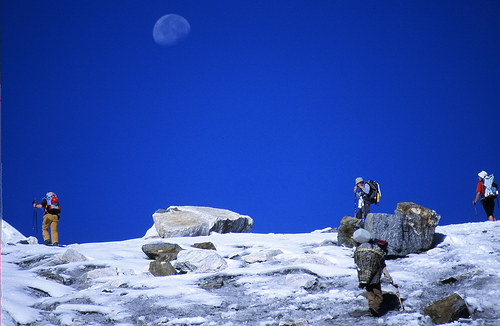

In [ ]:
x,y,z = next(iter(test_loader2))
x = x.to(device)
y = y.to(device)

with torch.no_grad():
  f = model0(x,y)

generated_cap = []
for i in f:
  generated_cap.append(torch.argmax(i, axis = 1))
for i in generated_cap:
  print(voc_itos[i[1].item()])
z[1]

<SOS>
a
girl
girl
in
running
a
beach
of
a
slide
.
<EOS>
<EOS>


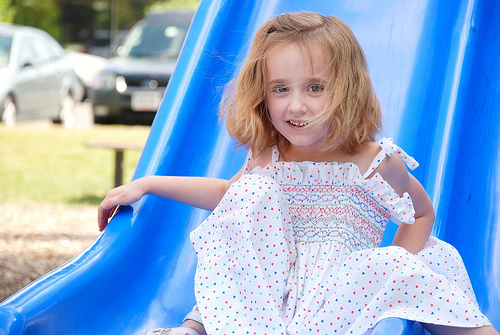

In [ ]:
generated_cap = []
for i in f:
  generated_cap.append(torch.argmax(i, axis = 1))
for i in generated_cap:
  print(voc_itos[i[2].item()])
z[2]

<SOS>
a
man
is
walking
the
canoe
area
.
.
<EOS>
<EOS>
.
.


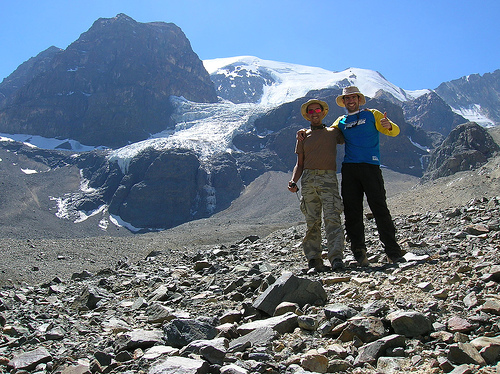

In [ ]:
generated_cap = []
for i in f:
  generated_cap.append(torch.argmax(i, axis = 1))
for i in generated_cap:
  print(voc_itos[i[0].item()])
z[0]

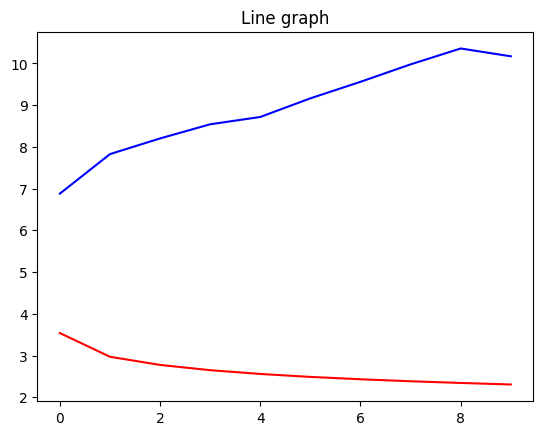

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
# data to be plotted
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = training_loss_history
y2 = validation_loss_history
# plotting
plt.title("Line graph")
plt.plot(x, y, color ="red")
plt.plot(x, y2, color ="blue")
plt.show()

<div dir='rtl'>تعریف پارامترها و مدل همراه با finetune کردن بخش CNN</div>

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_size = 256 #300
hidden_size = 256
vocab_size = len(voc_stoi)
learning_rate = 4e-4
epochs = 10 #10

model2 = (image_captioning(embed_size, hidden_size, vocab_size)).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=voc_stoi['<PAD>'])
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate) 

for name, param in model2.CNN.resnet.named_parameters():
  param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 80.5MB/s]


خلاصه مدل فوق

In [ ]:
model2.eval()

image_captioning(
  (CNN): image_captioning_CNN(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         

ترین مدل فوق

In [10]:
training_loss_history = []
validation_loss_history = []
for e in range(10):
  model2.train()
  training_loss = 0 
  for img, cap in tqdm(train_loader):
    img = img.to(device)
    cap = cap.to(device)
    output = model2(img, cap[:-1])
    #print(output.shape, cap.shape)     
    loss = loss_fn(output.reshape(-1, output.shape[2]), cap.reshape(-1))     
    training_loss += loss.item()   

    optimizer.zero_grad()  
    loss.backward()
    clip_grad_norm_(model2.parameters(), 0.001)
    optimizer.step()     
  training_loss = training_loss / len(train_loader)
  print("Epoch: ", e+1, "training_loss: ", training_loss)
  training_loss_history.append(training_loss)    

  print('validation phase: ')
  model2.eval()
  validation_loss = 0
  for img, cap in tqdm(test_loader):
    img = img.to(device)
    if cap.shape[0] > 16:
      cap = cap[0:16]
    else:
      padding = torch.zeros((16 - cap.shape[0], cap.shape[1]))
      cap = torch.cat((cap, padding), 0)
    cap = cap.type(torch.LongTensor) 
    cap = cap.to(device)    
    output = model2.validation_forward(img, cap[:-1])    
    output = torch.tensor(np.array([t.detach().cpu().numpy() for t in output])).to(device)        
    loss = loss_fn(output.reshape(-1, output.shape[2]), cap.reshape(-1))    
    validation_loss += loss.item()   
  validation_loss /= len(test_loader)
  print("Epoch: ", e+1, "validation_loss: ", validation_loss)
  validation_loss_history.append(validation_loss)

100%|██████████| 2213/2213 [17:48<00:00,  2.07it/s]


Epoch:  1 training_loss:  3.5395844541843586
validation phase: 


100%|██████████| 317/317 [02:40<00:00,  1.98it/s]


Epoch:  1 validation_loss:  7.166387902449358


100%|██████████| 2213/2213 [06:21<00:00,  5.80it/s]


Epoch:  2 training_loss:  3.0141489760023514
validation phase: 


100%|██████████| 317/317 [00:52<00:00,  6.08it/s]


Epoch:  2 validation_loss:  8.225674203517686


100%|██████████| 2213/2213 [06:21<00:00,  5.79it/s]


Epoch:  3 training_loss:  2.845124450464675
validation phase: 


100%|██████████| 317/317 [00:54<00:00,  5.85it/s]


Epoch:  3 validation_loss:  8.423460912253203


100%|██████████| 2213/2213 [06:25<00:00,  5.74it/s]


Epoch:  4 training_loss:  2.7400169264823133
validation phase: 


100%|██████████| 317/317 [00:54<00:00,  5.80it/s]


Epoch:  4 validation_loss:  8.711608256451338


100%|██████████| 2213/2213 [06:24<00:00,  5.75it/s]


Epoch:  5 training_loss:  2.659064422405741
validation phase: 


100%|██████████| 317/317 [00:53<00:00,  5.97it/s]


Epoch:  5 validation_loss:  8.879686722620052


100%|██████████| 2213/2213 [06:19<00:00,  5.82it/s]


Epoch:  6 training_loss:  2.59498990621709
validation phase: 


100%|██████████| 317/317 [00:53<00:00,  5.90it/s]


Epoch:  6 validation_loss:  8.919796701485426


100%|██████████| 2213/2213 [06:20<00:00,  5.82it/s]


Epoch:  7 training_loss:  2.5407637096453293
validation phase: 


100%|██████████| 317/317 [00:52<00:00,  6.03it/s]


Epoch:  7 validation_loss:  8.992247695802513


100%|██████████| 2213/2213 [06:18<00:00,  5.84it/s]


Epoch:  8 training_loss:  2.4958997895369635
validation phase: 


100%|██████████| 317/317 [00:53<00:00,  5.94it/s]


Epoch:  8 validation_loss:  8.506302886204764


100%|██████████| 2213/2213 [06:19<00:00,  5.84it/s]


Epoch:  9 training_loss:  2.4569125967331726
validation phase: 


100%|██████████| 317/317 [00:51<00:00,  6.14it/s]


Epoch:  9 validation_loss:  9.058240836351075


100%|██████████| 2213/2213 [06:19<00:00,  5.84it/s]


Epoch:  10 training_loss:  2.421041197492373
validation phase: 


100%|██████████| 317/317 [00:53<00:00,  5.93it/s]

Epoch:  10 validation_loss:  9.155194721763442


پیشبینی تصاویر مدل فوق:

<SOS>
a
people
boys
playing
on
a
beach
of
a
ocean
of
a
ocean
.
<EOS>
<EOS>


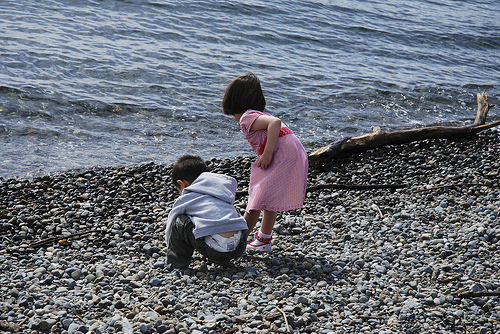

In [13]:
x,y,z = next(iter(test_loader2))
x = x.to(device)
y = y.to(device)

with torch.no_grad():
  f = model2(x,y)

generated_cap = []
for i in f:
  generated_cap.append(torch.argmax(i, axis = 1))
for i in generated_cap:
  print(voc_itos[i[1].item()])
z[1]

<SOS>
a
people
are
on
a
beach
of
a
arms
.
the
.
<EOS>
<EOS>
.
.


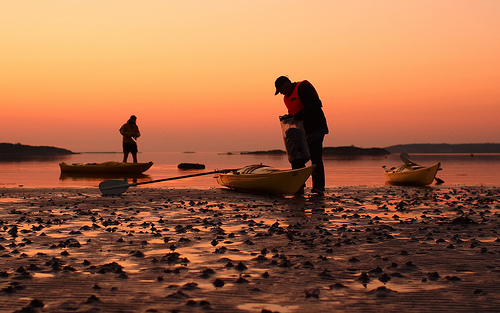

In [14]:
generated_cap = []
for i in f:
  generated_cap.append(torch.argmax(i, axis = 1))
for i in generated_cap:
  print(voc_itos[i[0].item()])
z[0]

<SOS>
a
man
is
a
man
.
.
<EOS>
<EOS>
.
.
.
.
.
.
.


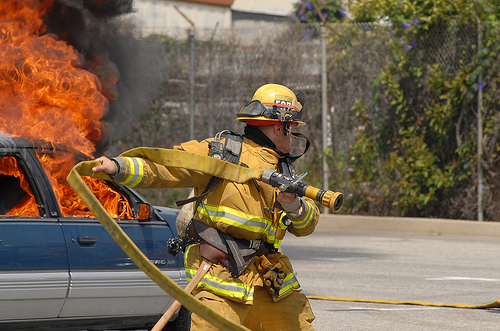

In [16]:
generated_cap = []
for i in f:
  generated_cap.append(torch.argmax(i, axis = 1))
for i in generated_cap:
  print(voc_itos[i[2].item()])
z[2]

<div dir = 'rtl'> نمودار loss مدل دوم </div>

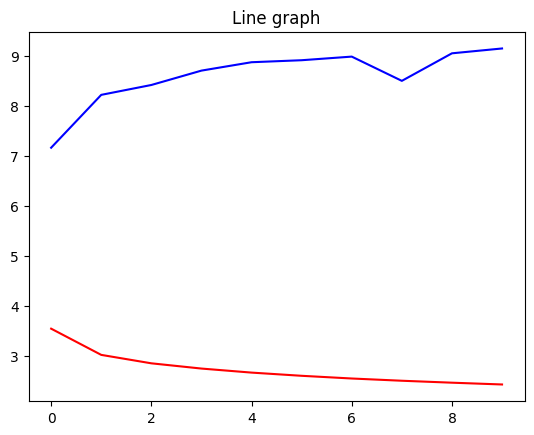

In [17]:
import numpy as np
import matplotlib.pyplot as plt
 
# data to be plotted
x = [0, 1, 2,3,4,5,6,7,8,9]
y = training_loss_history
y2 = validation_loss_history
# plotting
plt.title("Line graph")
plt.plot(x, y, color ="red")
plt.plot(x, y2, color ="blue")
plt.show()